In [4]:
import os
import multiprocessing

from json import loads

# from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kblab 
import math
from pandas.core.frame import DataFrame
from tqdm import tqdm
from urllib3.util import Retry
from urllib3 import PoolManager, make_headers
from kblab import Archive
import regex as re
from itertools import product
kblab.VERIFY_CA=False

In [5]:
years = range(1930, 1940)

In [6]:
df_content: DataFrame = pd.read_feather(f"/data/birdNewsData/data/df_content_{years[0]}s.feather")

In [7]:
df_content
df_numpy = np.array(df_content)
df_content

,content,dark_id,title,created
0,SVENSKA DAGBLADET Nr 248 Förmyndaredepositio...,dark-102238,SVENSKA DAGBLADET,1930-09-13
1,Lösnummer 15 öre (På tåg och båtar 20 öre Un...,dark-102243,SVENSKA DAGBLADET,1930-09-17
2,SVENSKA DAGBLADET Nr 51 KOL oce Stockholms...,dark-102273,SVENSKA DAGBLADET,1932-02-22
3,Nr 49 Stockholmsupplaga (Uppl A STOCKHOLM LÖ...,dark-102274,SVENSKA DAGBLADET,1932-02-20
4,SVENSKA DAGBLADET PH Dt HELMER KET huvudredak...,dark-102276,SVENSKA DAGBLADET,1932-02-15
...,...,...,...,...
10891,Halvårsskiftet stundar Prenumerera på Svenska ...,dark-25746,SVENSKA DAGBLADET,1939-06-27
10892,Nr 167 SVENSKA DAGBLADET Stockholmsupplaga (...,dark-25741,SVENSKA DAGBLADET,1939-06-25
10893,SVENSKA DAGBLADET STOCKHOLM ONSDAGEN DEN 21 J...,dark-25742,SVENSKA DAGBLADET,1939-06-21
10894,SVENSKA DAGBLADET LYmWN MtO MMNT (9 MKT SPÄNN...,dark-25750,SVENSKA DAGBLADET,1939-06-22


In [8]:
regex = r"\p{L}+"
def tokenize(text):
  return re.finditer(regex, text.lower())

In [9]:
def text_to_idx(words):
  wordCount = 0
  wordPos = {}
  for token in words:
    wordCount+=1
    word = token.group()
    pos = token.span()[0]
    if word in wordPos.keys():
      wordPos[word].append(pos)
    else:
      wordPos[word] = [pos]
  return wordPos, wordCount

In [10]:
tokens = tokenize("Men hallå där!")
idx, wordCount = text_to_idx(tokens)
print(wordCount)
idx.keys()

3


dict_keys(['men', 'hallå', 'där'])

In [1]:
def getDeclension(word):
  if word[-2:] == "ås":
    root = word[:-2]
    return [word, f"{word}en", f"{root}äss", f"{root}ässen"]
  if word[-2:] == "tt" or word[-2:] == "st":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "rt":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "t":
    root = word[:-1]
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-3:] == "gam":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "m":
    return [word, f"{word}men", f"{word}mar", f"{word}marna"]
  if word[-2:] == "ss":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "a":
    root = word[:-1]
    return [word, f"{root}an", f"{root}or", f"{root}orna"]
  if word[-2:] == "yr":
    root = word[:-2]
    return [word, f"{word}en", f"{root}rar", f"{root}rarna"]
  if word[-3:] == "ger":
    root = word[:-2]
    return [word, f"{root}ern", f"{root}rar", f"{root}rarna"]
  if word[-1:] == "r" and (not word[-2:] == "är"):
    root = word[:-1]
    return [word, f"{word}et", f"{word}", f"{word}en"]
  if word[-1:] == "d":
    root = word[:-3]
    return [word, f"{word}et", f"{root}änder", f"{root}änderna"]
  if word[-3:] == "are" and (not word[-5:] == "stare"):
    root = word[:-1]
    return [word, f"{root}en", f"{root}e", f"{root}na"]
  if word[-2:] == "re":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-1:] == "e":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-4:] == "rell":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "ll":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "yl" or word[-3:] == "nal":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-3:] == "gal":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "l":
    root = word[:-2] 
    return [word, f"{root}eln", f"{root}lar", f"{root}larna"]
  if word[-2:] == "ag":
    root = word 
    return [word, f"{root}et", f"{root}", f"{root}en"]
  if word[-1:] == "g":
    root = word 
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "um":
    root = word[:-2] 
    return [word, f"{root}en", f"{root}nar", f"{root}narna"]
  if word[-2:] == "en":
    root = word[:-2] 
    return [word, f"{root}nen", f"{root}er", f"{root}erna"]
  if word[-2:] == "an":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "ur" or word[-2:] == "är":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "nd":
    root = word[:-3]
    return [word, f"{word}en", f"{root}änder", f"{word}änderna"]
  if word[-1:] == "ö":
    return [word, f"{word}n", f"{word}ar", f"{word}arna"]
  if word[-2:] == "es":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "rk" or word[-2:] == "nk":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "ök" or word[-2:] == "åk" or word[-2:] == "lk" or word[-2:] == "ck":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "k":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "o":
    return [word, f"{word}n", f"{word}er", f"{word}rna"]
  if word[-1:] == "s" and (not word[-2:] == "is" or not word[-2] == "es"):
    return [word, f"{word}et", f"{word}", f"{word}en"]
  else:
    root = word
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]


In [2]:
getDeclension("gås")

['gås', 'gåsen', 'gäss', 'gässen']

In [13]:
birds = pd.read_csv("birds2.csv", header=0)
natureTypes = pd.read_csv("naturtyper.csv", header=0)
wordChecklist = natureTypes.copy()
natureTypes.iloc[0]["naturtyp"]
birds

,namn
0,fågel
1,andfågel
2,gås
3,svan
4,brantagås
...,...
1258,sjöfågel
1259,tropikflyttare
1260,storkartade fågel
1261,doppingfågel


In [14]:
def addWords(word, onlyDeclension = True): 
    global wordChecklist
    if onlyDeclension:
        wordDec = getDeclension(word)[1:]
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2]], columns=["naturtyp"])
    else:
        wordDec = getDeclension(word)
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2],wordDec[3]], columns=["naturtyp"])
    wordChecklist = pd.concat([wordChecklist,wordDecFrame])


In [15]:
from transformers import AutoModel,pipeline

ner = pipeline('ner', model='KB/bert-base-swedish-cased-ner', tokenizer='KB/bert-base-swedish-cased-ner')
pos = pipeline("token-classification", model="KBLab/bert-base-swedish-cased-pos", tokenizer="KBLab/bert-base-swedish-cased-pos")
sentiment = pipeline("text-classification", model="KBLab/robust-swedish-sentiment-multiclass")




/home/tmpuser/code/Exjobb-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-05 14:10:53.400744: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 14:10:53.444149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 14:10:54.434153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at KB/bert-base-swedish-cased-ner were not used when initializing BertForTokenClassification: ['bert.pool

In [16]:
def getVerbs(text):
    posText = pos(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] == "VB", l))]

In [17]:
def getNamed(text):
    interestingTags = ["PRS", "LOC", "ORG", "OBJ"]
    posText = ner(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] in interestingTags, l))]    

In [18]:
master_index = {}
yearCounts = {}

for y in years:
    yearCounts.update({str(y):0})
totalCount = 0
tmp = 0

def addToIndex(row):
    global master_index
    tokens = tokenize(row["content"])
    idx, wordCount = text_to_idx(tokens)
    year = row["created"][:4]
    yearCounts[year] += wordCount
    for word in idx.keys():
        #if word in wordChecklist["svenskt namn"].values:
            if word in master_index:
                master_index[word][row["dark_id"], year] = idx[word]
            else:
                master_index[word] = {(row["dark_id"], year):idx[word]}
        


In [19]:
len(master_index)

0

In [20]:
df_content.apply(lambda row: addToIndex(row), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
10891    None
10892    None
10893    None
10894    None
10895    None
Length: 10896, dtype: object

In [21]:
def counter(word):
  master_index_bird = master_index[word]
  count = {}

  for y in years:
    count.update({str(y): {"freq":0, "count":0, "prob":0}})
  for a,b in master_index_bird:
    if b in count:
      count[b]["count"] += 1
    else:
      count[b]["count"] = 1
  for y in years:
    try:
      count[str(y)]["freq"] = count[str(y)]["count"]/yearCounts[str(y)]*100000
      count[str(y)]["prob"] = count[str(y)]["count"]/yearCounts[str(y)]
    except:
      count[str(y)]["freq"] = 0.0
  return count


4

In [22]:
def getWordCooccurenceAndSentiment(word):
  yearsString = [str(y) for y in years]
  master_index_bird = master_index[word]
  sentimentByYear = {}
  global df_numpy
  cooccurence = {}
  for y in years:
    cooccurence.update({str(y):{}})
    sentimentByYear.update({str(y):[]})
  for issue, year in master_index_bird:
    rows, cols = np.where(df_numpy == issue)
    textBlock = df_numpy[rows][0][0].lower().replace(",", "")
    n = 5
    lhs, bird, rhs = textBlock.partition(word)
    window = lhs.split()[-n:] + rhs.split()[:n]
    sentimentWindow = " ".join(lhs.split()[-n:] + [bird] + rhs.split()[:n])
    if len(sentimentWindow) > 256:
      sentimentWindow = lhs[-128:] + bird + rhs[128:]
    textSentiment = sentiment(sentimentWindow)[0]["label"]
    sentimentByYear[year].append(textSentiment)
    birdWords = list(filter(None, window))
    #verbs = getVerbs(" ".join(birdWords))
    #named = getNamed(tmp)
    #natureWords = [k for k in birdWords if k in wordChecklistList]
    #interestingWords = verbs + natureWords
    #print(f"all: {birdWords}")
    #print(f"verbs {verbs}")
    #print(f"nature: {natureWords}")
    for bWord in birdWords:
      if bWord == word or bWord in yearsString:
        continue
      if bWord in cooccurence[year]:
        cooccurence[year][bWord] += 1
      else:
        cooccurence[year][bWord] = 1
      #print(f"checking {bWord}")    
  return cooccurence, sentimentByYear

In [23]:
def sortCooccurence(a):
  return sorted(a.items(), key=lambda x:x[1], reverse=True)

In [24]:
def mergeCounts(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {"freq": c1[str(y)]["freq"] + c2[str(y)]["freq"], "count": c1[str(y)]["count"] + c2[str(y)]["count"], "prob": c1[str(y)]["prob"] + c2[str(y)]["prob"]}
  return tmp


In [25]:
def mergeCoocs(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {k: (c1[str(y)].get(k, 0) + c2[str(y)].get(k, 0)) for k in set(c1[str(y)]) | set(c2[str(y)])}
  return tmp

In [26]:
def mergeSentiment(s1,s2):
    tmp = {}
    for y in years:
        tmp1 = s1[str(y)]
        tmp2 = s2[str(y)]
        tmp[str(y)] = tmp1+tmp2
    return tmp

In [27]:

frequency = {}
cooccurenceMatrix = {}

for i, bird in birds.iterrows():
  specificbird = bird["namn"]
  birds_dec = getDeclension(specificbird)
  for bd in birds_dec:
    try:
      bc = counter(bd)
      if bird[0] in frequency:
        freq = frequency[specificbird]
      else:
        freq = {}
        for y in years:
          freq.update({str(y):{"freq":0, "count":0, "prob":0}})
      frequency[specificbird] = mergeCounts(bc, freq)
    except:
      "lmao"

/tmp/ipykernel_562619/3438062497.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if bird[0] in frequency:


In [28]:
frequency.keys()
dataFreq = {}
dataCount = {}

for b in frequency.keys():
    dataFreq.update({b: [frequency[b][x]["freq"] for x in frequency[b]]})
    dataCount.update({b: [frequency[b][x]["count"] for x in frequency[b]]})




In [29]:
dfFreq = pd.DataFrame.from_dict(dataFreq, orient="index", columns=years)
dfCount = pd.DataFrame.from_dict(dataCount, orient="index", columns=years)
dfFreq.to_feather(f"/data/birdNewsData/birdFreq/dfFreq_{years[0]}s.feather")
dfCount.to_feather(f"/data/birdNewsData/birdFreq/dfCount_{years[0]}s.feather")

In [30]:
pd.DataFrame.from_dict(yearCounts, orient="index", columns=["word count"]).to_feather(f"/data/birdNewsData/birdFreq/dfYearCount_{years[0]}s.feather")

In [31]:
pd.read_feather(f"/data/birdNewsData/birdFreq/dfFreq_{years[0]}s.feather")

,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939
fågel,1.591077,1.664948,1.668208,1.949352,1.917375,1.845351,1.874382,2.296258,2.374701,1.959831
andfågel,0.002814,0.001444,0.002879,0.004266,0.002834,0.004128,0.006968,0.008432,0.005188,0.005344
gås,1.063532,1.114779,1.044969,1.074916,1.077018,1.155924,1.028471,1.160777,1.099807,1.301210
svan,0.786394,0.749443,0.565665,0.648362,0.619285,0.598604,0.590883,0.587415,0.653659,0.589152
prutgås,0.000000,0.004332,0.000000,0.000000,0.000000,0.002752,0.002787,0.000000,0.001297,0.002672
...,...,...,...,...,...,...,...,...,...,...
skogssångare,0.002814,0.000000,0.000000,0.001422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kardinal,0.241967,0.174726,0.149693,0.159247,0.201232,0.232561,0.225762,0.229064,0.320345,0.287228
havsfågel,0.004220,0.005776,0.002879,0.004266,0.002834,0.005504,0.004181,0.002811,0.003891,0.001336
nattsångare,0.002814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002811,0.000000,0.002672


In [32]:

for i, bird in birds.iterrows():
    specificbird = bird["namn"]
    print(specificbird)
    birds_dec = getDeclension(specificbird)
    print(birds_dec)

    cooccurenceMatrix = {}
    sentimentMatrix = {}
    for bd in birds_dec:
        print(f"{bd} start")
        try:
            coWord, senWord = getWordCooccurenceAndSentiment(bd)
            if specificbird in cooccurenceMatrix:
                co = cooccurenceMatrix[specificbird]
                cooccurenceMatrix[specificbird] = mergeCoocs(co, coWord)
            else:
                cooccurenceMatrix[specificbird] = coWord

            if specificbird in sentimentMatrix:
                se = sentimentMatrix[specificbird]
                sentimentMatrix[specificbird] = mergeSentiment(se, senWord)
            else:
                sentimentMatrix[specificbird] = senWord
        except:
            print(f"{bd} not found in index")
        print(f"{bd} done")
    try:
        pd.DataFrame.from_dict(cooccurenceMatrix[specificbird]).to_feather(f"/data/birdNewsData/birdFreq/df_co_{years[0]}s_{specificbird}.feather")
    
        specificSentiment = sentimentMatrix[specificbird]
        tmp = {}
        for y in years:
            yearlySentiment = specificSentiment[str(y)]
            countNegative = yearlySentiment.count("NEGATIVE")
            countPositive = yearlySentiment.count("POSITIVE")
            CountNeutral = yearlySentiment.count("NEUTRAL")
            tmp[y] = {"Positive": countPositive,"Neutral":CountNeutral, "Negative" : countNegative}
        pd.DataFrame.from_dict(tmp).to_feather(f"/data/birdNewsData/birdFreq/df_sen_{years[0]}s_{specificbird}.feather")

        coWordsPerBird = getCoWordsCount(specificbird)
        df_coCount = pd.DataFrame.from_dict(coWordsPerBird, orient="index", columns=years)
        df_coCount.to_feather(f"/data/birdNewsData/birdFreq/df_coWord_{years[0]}s_{specificbird}.feather")
    except:
        print(f"{specificbird} not found in decade")

        



fågel
['fågel', 'fågeln', 'fåglar', 'fåglarna']
fågel start
fågel done
fågeln start
fågeln done
fåglar start
fåglar done
fåglarna start
fåglarna done


In [33]:

def getCoWordsCount(bird):
    tmp = 0
    specificMatrix = cooccurenceMatrix[bird]
    SavedCounts = {}
    for y in years:
        for x in specificMatrix[str(y)].keys():
            if not (x in SavedCounts):
                try:
                    tmp1 = [counter(x)[str(y)]["count"] for y in years]
                    SavedCounts[x] = tmp1
                except:
                    "not in index..."
    return SavedCounts

In [37]:
def getTScore(bird, year):
  ts = {}
  skipwords = ["och", "i", "en", "som", "att", "kan", "den", "ett"]
  for word, count_co in cooccurenceMatrix[bird][year].items():
    if word in skipwords:
      continue
    try:
      count_word = counter(word)[year]["count"]
      prob_word = count_word/yearCounts[year] *100000
      prob_bird = frequency[bird][year]["freq"]
      prob_both = count_co/yearCounts[year] * 100000

      ts[word] = ((
        prob_both -
        prob_bird *
        prob_word /
        yearCounts[year] /
        math.sqrt(prob_both)
      ))
    except:
      "lmao"
  return sorted(ts.items(), key=lambda x:x[1], reverse=True)[:10]
  

In [38]:
def getPMIs(bird, year):
  tmp = []
  count_bird = frequency[bird][year]["count"]
  #print("count b\t", count_bird)
  prob_bird = frequency[bird][year]["prob"]
  #print("prob b\t", prob_bird)
  i = 0
  for word, count_co in cooccurenceMatrix["Domherre"][year].items():
    try:
      print(word)
      i+=1
      if i > 5:
        break; 
      count_word = counter(word)[year]["count"]
      #print("count w\t", count_word)
      prob_word = count_word/yearCounts[year]
      #print("prob w\t", prob_word)
      #print("count co w\t", count_co)
      prob = count_co/yearCounts[year]
      #print("total prob\t", prob)
      pmi = max(math.log(prob/(prob_bird*prob_word)),0)
      #print("pmi\t", pmi)
      tmp.append((word, pmi))
      #print()
    except:
      "oof"
  return sorted(tmp, key=lambda x:x[1], reverse=True)

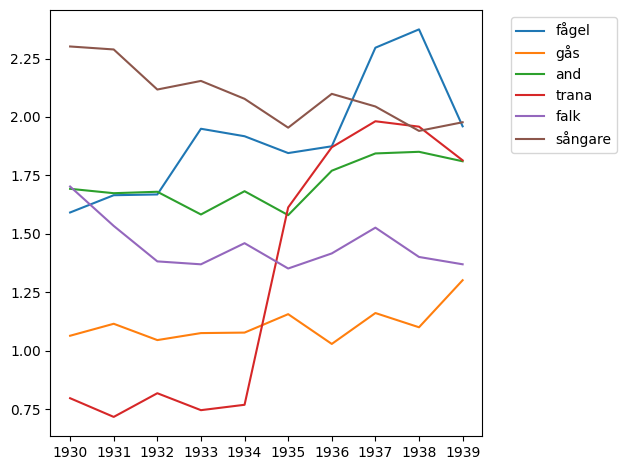

In [39]:
tmp = 0

for bird, freq in frequency.items():
  tmp +=1
  onlyFreqs = {}
  avg = 0
  for f in freq:
    onlyFreqs.update({str(f): freq[f]["freq"]})
    avg += freq[f]["freq"]/10
  if avg > 1:
    plt.plot(onlyFreqs.keys(), onlyFreqs.values(), label=bird)



plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()
